In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!pip install evaluate
!pip install -U transformers accelerate datasets evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompati

In [ ]:

import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/medec_full_dataset.csv")

df.head()

,Text ID,Text,Sentences,Error Flag,Error Type,Error Sentence ID,Error Sentence,Corrected Sentence,Corrected Text,split
0,ms-train-0,A 53-year-old man comes to the physician becau...,0 A 53-year-old man comes to the physician bec...,1.0,causalOrganism,6.0,"After reviewing imaging, the causal pathogen w...","After reviewing imaging, the causal pathogen w...",A 53-year-old man comes to the physician becau...,train
1,ms-train-1,A 53-year-old man comes to the physician becau...,0 A 53-year-old man comes to the physician bec...,0.0,NaN,-1.0,NaN,NaN,NaN,train
2,ms-train-2,A 9-year-old girl is brought to the pediatrici...,0 A 9-year-old girl is brought to the pediatri...,1.0,causalOrganism,10.0,Suspected of infection with Giardia lamblia.,Suspected of infection with Enterobius vermicu...,A 9-year-old girl is brought to the pediatrici...,train
3,ms-train-3,A 9-year-old girl is brought to the pediatrici...,0 A 9-year-old girl is brought to the pediatri...,0.0,NaN,-1.0,NaN,NaN,NaN,train
4,ms-train-4,Blood cultures are sent to the laboratory. Int...,0 Blood cultures are sent to the laboratory.\n...,1.0,causalOrganism,3.0,Causal organism is Staphylococcus epidermidis.,Causal organism is Staphylococcus aureus.,Blood cultures are sent to the laboratory. Int...,train


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
text_cols = ["Sentences", "Error Sentence", "Corrected Sentence", "Corrected Text"]
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

df["Error Flag"] = df["Error Flag"].fillna(0).astype(int)

df = df[~((df["Error Flag"] == 1) & (df["Corrected Sentence"].isna()))]

df["Error Type"] = df["Error Type"].fillna("NoError")
label_encoder = LabelEncoder()
df["Error Type ID"] = label_encoder.fit_transform(df["Error Type"])


label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

classification_df = df[["Sentences", "Error Flag", "Error Type", "Error Type ID"]]

correction_df = df[df["Error Flag"] == 1][["Error Sentence", "Corrected Sentence", "Error Type", "Error Type ID"]]

print("Datasets prepared:")
print("Classification shape:", classification_df.shape)
print("Correction shape:", correction_df.shape)


Label Mapping: {'NoError': np.int64(0), 'causalOrganism': np.int64(1), 'diagnosis': np.int64(2), 'management': np.int64(3), 'pharmacotherapy': np.int64(4), 'treatment': np.int64(5)}
Datasets prepared:
Classification shape: (3688, 4)
Correction shape: (1849, 4)


In [ ]:
classification_df = classification_df[classification_df["Error Type"] != "NoError"].copy()
correction_df = correction_df[correction_df["Error Type"] != "NoError"].copy()
classification_df.shape

(1849, 4)

In [ ]:
classification_df

,Sentences,Error Flag,Error Type,Error Type ID
0,0 A 53-year-old man comes to the physician bec...,1,causalOrganism,1
2,0 A 9-year-old girl is brought to the pediatri...,1,causalOrganism,1
4,0 Blood cultures are sent to the laboratory.\n...,1,causalOrganism,1
6,0 A 5-year-old male is brought to the pediatri...,1,causalOrganism,1
8,0 A previously healthy 48-year-old man comes t...,1,causalOrganism,1
...,...,...,...,...
3679,0 A 59-year-old male with history of hypertens...,1,treatment,5
3681,0 A 53-year-old man presents to your office wi...,1,treatment,5
3683,0 A 20-year-old woman presents to the emergenc...,1,treatment,5
3685,0 A 26-year-old male comes into your clinic co...,1,treatment,5


In [ ]:
import pandas as pd
from transformers import AutoTokenizer


try:
    tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
    tokenized_data = tokenizer(
    list(classification_df["Sentences"].values),
    truncation=True,
    padding="max_length",
    max_length=512,
    return_tensors="pt"
    )


    classification_df["input_ids"] = tokenized_data["input_ids"].tolist()
    classification_df["attention_mask"] = tokenized_data["attention_mask"].tolist()

    print("Tokenization complete. New columns added to classification_df.")
    print("Updated classification_df columns:", classification_df.columns)

except ImportError:
    print("The 'transformers' library is not installed. Please install it with: pip install transformers")
except Exception as e:
    print(f"An error occurred during tokenization: {e}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Tokenization complete. New columns added to classification_df.
Updated classification_df columns: Index(['Sentences', 'Error Flag', 'Error Type', 'Error Type ID', 'input_ids',
       'attention_mask'],
      dtype='object')


In [ ]:
classification_df.rename(columns={'Error Type ID': 'labels'}, inplace=True)

In [ ]:
classification_df['labels'] = classification_df['labels'].astype(int) - 1

print("DataFrame after renaming and remapping:")
print(classification_df)

DataFrame after renaming and remapping:
                                              Sentences  Error Flag  \
0     0 A 53-year-old man comes to the physician bec...           1   
2     0 A 9-year-old girl is brought to the pediatri...           1   
4     0 Blood cultures are sent to the laboratory.\n...           1   
6     0 A 5-year-old male is brought to the pediatri...           1   
8     0 A previously healthy 48-year-old man comes t...           1   
...                                                 ...         ...   
3679  0 A 59-year-old male with history of hypertens...           1   
3681  0 A 53-year-old man presents to your office wi...           1   
3683  0 A 20-year-old woman presents to the emergenc...           1   
3685  0 A 26-year-old male comes into your clinic co...           1   
3686  0 A 56-year-old woman with a history of alcoho...           1   

          Error Type  labels  \
0     causalOrganism       0   
2     causalOrganism       0   
4     causa

In [ ]:

all_labels = classification_df["Error Type"].dropna().unique().tolist()

if "NoError" in all_labels:
    all_labels.remove("NoError")

all_labels.sort()


label2id = {name: i for i, name in enumerate(all_labels)}
id2label = {i: name for name, i in label2id.items()}

print("Label2id:", label2id)
print("Id2label:", id2label)

classification_df["Error Type ID"] = classification_df["Error Type"].map(label2id)
correction_df["Error Type ID"] = correction_df["Error Type"].map(label2id)


Label2id: {'causalOrganism': 0, 'diagnosis': 1, 'management': 2, 'pharmacotherapy': 3, 'treatment': 4}
Id2label: {0: 'causalOrganism', 1: 'diagnosis', 2: 'management', 3: 'pharmacotherapy', 4: 'treatment'}


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_df, temp_df = train_test_split(
    classification_df,
    test_size=0.3,  #train 70%
    random_state=42,
    stratify=classification_df['labels']
)


val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  #Remaining 30% - 15% test & 15% val
    random_state=42,
    stratify=temp_df['labels']
)


print(f"Total dataset size: {len(classification_df)}")
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

print("\n--- Class Distribution in Each Set ---")
print("Training set distribution:")
print(train_df['Error Type'].value_counts())
print("\nValidation set distribution:")
print(val_df['Error Type'].value_counts())
print("\nTest set distribution:")
print(test_df['Error Type'].value_counts())

Total dataset size: 1849
Training set size: 1294
Validation set size: 277
Test set size: 278

--- Class Distribution in Each Set ---
Training set distribution:
Error Type
management         598
diagnosis          373
treatment          134
pharmacotherapy    128
causalOrganism      61
Name: count, dtype: int64

Validation set distribution:
Error Type
management         128
diagnosis           80
treatment           29
pharmacotherapy     27
causalOrganism      13
Name: count, dtype: int64

Test set distribution:
Error Type
management         128
diagnosis           80
treatment           29
pharmacotherapy     28
causalOrganism      13
Name: count, dtype: int64


In [ ]:
# ----------------------------
# Reproducibility setup
# ----------------------------
import torch
import numpy as np
import random
import os
from transformers import set_seed

seed = 42

# Python & NumPy
np.random.seed(seed)
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)


torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
set_seed(seed)


In [ ]:
from datasets import Dataset

# Convert DataFrames → HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset   = Dataset.from_pandas(val_df)
test_dataset  = Dataset.from_pandas(test_df)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Class Weights: tensor([0.4330, 0.6938, 1.9260, 2.0208, 4.2506])

========== Training ClinicalBERT ==========


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3155179325.py:112: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc
1,No log,1.187831,0.454874,0.309550,0.716006
2,No log,0.855398,0.729242,0.666394,0.908243
3,No log,0.762284,0.740072,0.691632,0.929678
4,No log,0.747289,0.772563,0.760395,0.938605
5,No log,0.796986,0.750903,0.743639,0.931668
6,No log,0.887626,0.740072,0.748311,0.933370
7,0.716200,0.993337,0.758123,0.768666,0.930534
8,0.716200,1.049632,0.761733,0.770548,0.931709
9,0.716200,1.194913,0.765343,0.772443,0.926306
10,0.716200,1.220791,0.754513,0.764688,0.925808


ClinicalBERT Test Results: {'eval_loss': 1.0229953527450562, 'eval_accuracy': 0.7697841726618705, 'eval_f1': 0.7783037366066303, 'eval_auc': 0.9321552365084724, 'eval_runtime': 8.5231, 'eval_samples_per_second': 32.617, 'eval_steps_per_second': 2.112, 'epoch': 10.0}

========== Training BioBERT ==========


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3155179325.py:112: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc
1,No log,1.037993,0.555957,0.467284,0.871023
2,No log,0.710136,0.718412,0.691743,0.938706
3,No log,0.784920,0.779783,0.749628,0.938882
4,No log,0.994903,0.797834,0.775421,0.932379
5,No log,0.958885,0.801444,0.792591,0.938854
6,No log,1.050951,0.815884,0.810790,0.936706
7,0.573200,1.246031,0.815884,0.812080,0.933042
8,0.573200,1.347051,0.808664,0.814046,0.929017
9,0.573200,1.451662,0.797834,0.794399,0.927196
10,0.573200,1.465234,0.808664,0.806695,0.927419


BioBERT Test Results: {'eval_loss': 1.229785442352295, 'eval_accuracy': 0.7985611510791367, 'eval_f1': 0.8089826456076961, 'eval_auc': 0.929930520144012, 'eval_runtime': 8.1614, 'eval_samples_per_second': 34.063, 'eval_steps_per_second': 2.206, 'epoch': 10.0}

========== ClinicalBERT Test Analysis ==========


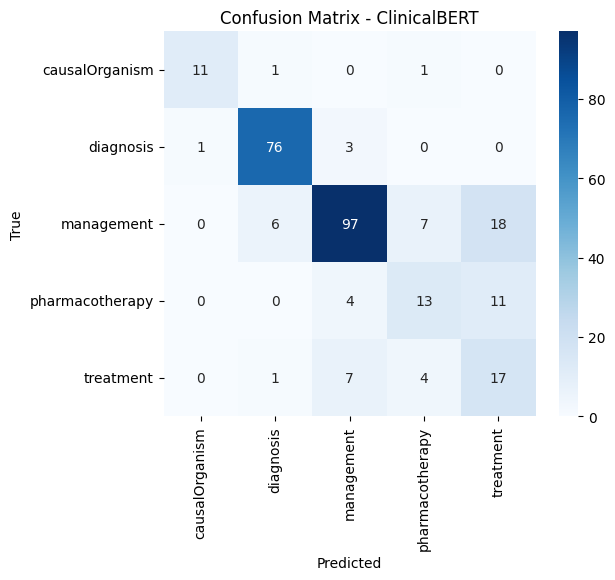

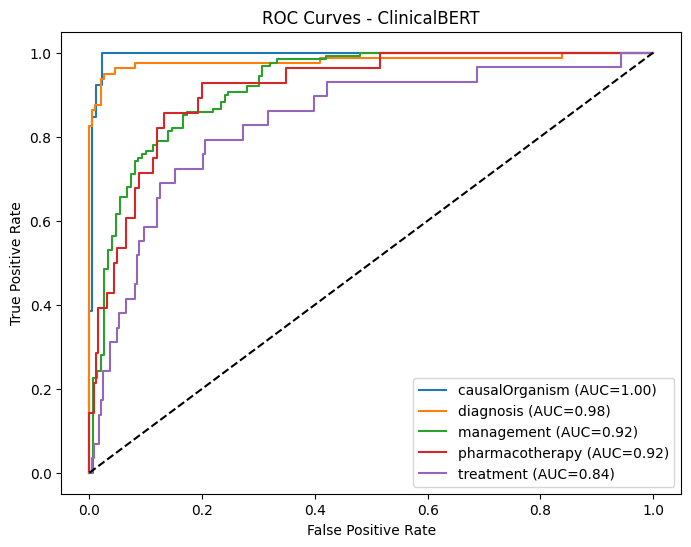


========== BioBERT Test Analysis ==========


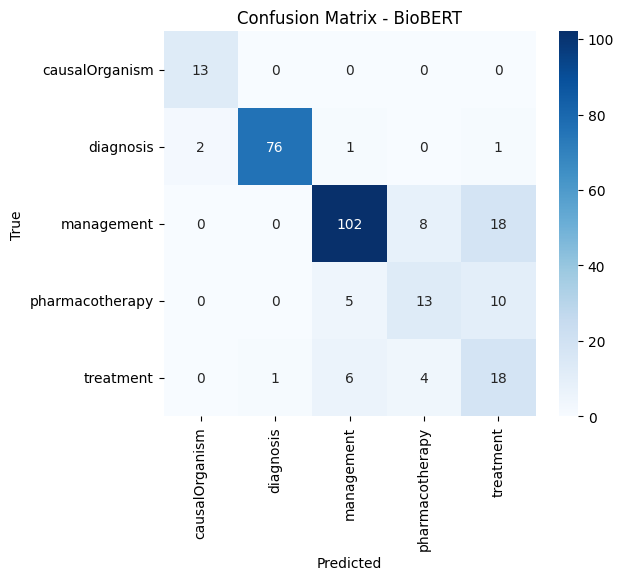

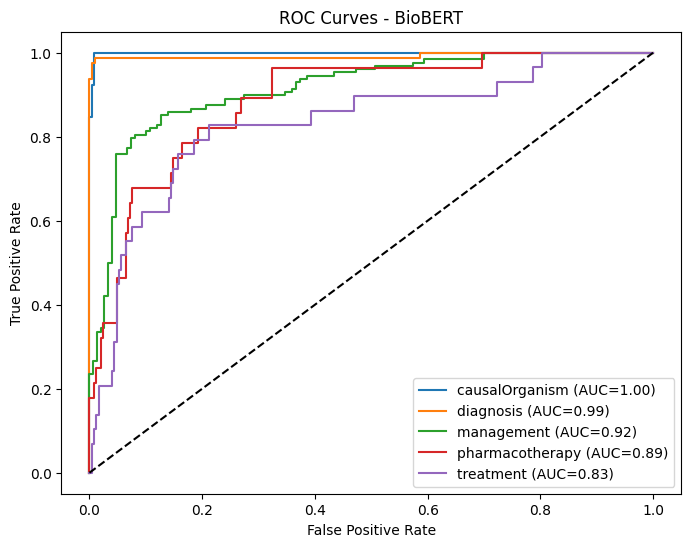


========== Model Comparison ==========
ClinicalBERT: Accuracy=0.7698, F1=0.7783, AUC=0.9322
BioBERT: Accuracy=0.7986, F1=0.8090, AUC=0.9299


In [ ]:
# ----------------------------
# Imports
# ----------------------------
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import torch
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# ----------------------------
# Metrics
# ----------------------------
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

    metrics = {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
    }

    try:
        metrics["auc"] = roc_auc_score(labels, probs, multi_class="ovr", average="weighted")
    except Exception:
        metrics["auc"] = float("nan")

    return metrics

# ----------------------------
# Class Weights
# ----------------------------
class_counts = {
    "management": 854,
    "diagnosis": 533,
    "treatment": 192,
    "pharmacotherapy": 183,
    "causalOrganism": 87
}

labels = list(class_counts.keys())
counts = np.array(list(class_counts.values()))
total = counts.sum()
class_weights = total / (len(counts) * counts)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class Weights:", class_weights)

# ----------------------------
# Weighted Trainer Class
# ----------------------------
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")

        if isinstance(labels, list):
            labels = torch.tensor(labels, dtype=torch.long, device=model.device)
        else:
            labels = labels.to(model.device).long()

        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# ----------------------------
# Models to Compare
# ----------------------------
models_to_try = {
    "ClinicalBERT": "emilyalsentzer/Bio_ClinicalBERT",
    "BioBERT": "dmis-lab/biobert-base-cased-v1.2"
}

# ----------------------------
# Train and Store Results
# ----------------------------
trainers = {}
results = {}

for model_name, model_ckpt in models_to_try.items():
    print(f"\n========== Training {model_name} ==========")

    model = AutoModelForSequenceClassification.from_pretrained(
        model_ckpt,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir=f"./results_{model_name}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=10,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        logging_dir=f"./logs_{model_name}",
        report_to="none"
    )

    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    trainers[model_name] = trainer

    test_results = trainer.evaluate(test_dataset)
    results[model_name] = test_results
    print(f"{model_name} Test Results:", test_results)

# ----------------------------
# Evaluation and Plots
# ----------------------------
def evaluate_and_plot(trainer, model_name, test_dataset, label2id):
    preds_output = trainer.predict(test_dataset)
    logits = preds_output.predictions
    labels = preds_output.label_ids
    preds = np.argmax(logits, axis=-1)

    # --- Confusion Matrix ---
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label2id.keys(),
                yticklabels=label2id.keys())
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # --- ROC Curves ---
    n_classes = len(label2id)
    y_true_bin = label_binarize(labels, classes=list(range(n_classes)))
    y_score = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

    plt.figure(figsize=(8, 6))
    for i, label in enumerate(label2id.keys()):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.title(f"ROC Curves - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# ----------------------------
# Run Evaluation for Each Model
# ----------------------------
for model_name, trainer in trainers.items():
    print(f"\n========== {model_name} Test Analysis ==========")
    evaluate_and_plot(trainer, model_name, test_dataset, label2id)

# ----------------------------
# Print Summary Comparison
# ----------------------------
print("\n========== Model Comparison ==========")
for model_name, res in results.items():
    print(f"{model_name}: Accuracy={res['eval_accuracy']:.4f}, F1={res['eval_f1']:.4f}, AUC={res['eval_auc']:.4f}")


In [ ]:
# ----------------------------
# Save models to Google Drive
# ----------------------------
save_base_path = "/content/drive/MyDrive/Clinical_NLP_Models"  # rename folder as you like

import os
os.makedirs(save_base_path, exist_ok=True)

for model_name, trainer in trainers.items():
    save_path = os.path.join(save_base_path, f"saved_{model_name}")
    trainer.save_model(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"Model saved to: {save_path}")


✅ Model saved to: /content/drive/MyDrive/Clinical_NLP_Models/saved_ClinicalBERT
✅ Model saved to: /content/drive/MyDrive/Clinical_NLP_Models/saved_BioBERT


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "ClinicalBERT"  # or "BioBERT"
path = f"/content/drive/MyDrive/Clinical_NLP_Models/saved_{model_name}"

model = AutoModelForSequenceClassification.from_pretrained(path)
tokenizer = AutoTokenizer.from_pretrained(path)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 4.7 MB/s eta 0:00:00


In [ ]:
# ==========================================
#  Imports
# ==========================================
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import torch
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# ==========================================
#  Define label mappings
# ==========================================
label2id = {
    "management": 0,
    "diagnosis": 1,
    "treatment": 2,
    "pharmacotherapy": 3,
    "causalOrganism": 4
}
id2label = {v: k for k, v in label2id.items()}

# ==========================================
#  Tokenizer
# ==========================================
# (You can switch the model name as needed later)
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# ==========================================
#  Metrics
# ==========================================
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

    metrics = {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
    }

    try:
        metrics["auc"] = roc_auc_score(labels, probs, multi_class="ovr", average="weighted")
    except Exception:
        metrics["auc"] = float("nan")

    return metrics

# ==========================================
#  Class Weights
# ==========================================
class_counts = {
    "management": 854,
    "diagnosis": 533,
    "treatment": 192,
    "pharmacotherapy": 183,
    "causalOrganism": 87
}
counts = np.array(list(class_counts.values()))
total = counts.sum()
class_weights = total / (len(counts) * counts)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class Weights:", class_weights)

# ==========================================
# Weighted Trainer Class
# ==========================================
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")

        if isinstance(labels, list):
            labels = torch.tensor(labels, dtype=torch.long, device=model.device)
        else:
            labels = labels.to(model.device).long()

        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# ==========================================
#  Models to Compare
# ==========================================
models_to_try = {
    "ClinicalBERT": "emilyalsentzer/Bio_ClinicalBERT",
    "BioBERT": "dmis-lab/biobert-base-cased-v1.2"
}




Class Weights: tensor([0.4330, 0.6938, 1.9260, 2.0208, 4.2506])


In [ ]:
def model_hp_search(model_ckpt, model_name, train_dataset, val_dataset, tokenizer):
    model_init = lambda: AutoModelForSequenceClassification.from_pretrained(
        model_ckpt,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir=f"./tuned_{model_name}",
        eval_strategy="epoch",
        save_strategy="no",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        metric_for_best_model="f1",
        logging_dir=f"./logs_tuned_{model_name}",
        report_to="none"
    )

    trainer = WeightedTrainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    def optuna_hp_space(trial):
        return {
            "learning_rate": trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True),
            "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
            "num_train_epochs": trial.suggest_categorical("num_train_epochs", [3, 5]),
            "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1)
        }

    best_trial = trainer.hyperparameter_search(
        direction="maximize",
        backend="optuna",
        n_trials=5,
        hp_space=optuna_hp_space
    )

    print(f"\n Best Hyperparameters for {model_name}:")
    print(best_trial)
    return best_trial


In [ ]:
best_hp_biobert = model_hp_search("dmis-lab/biobert-base-cased-v1.2", "BioBERT", train_dataset, val_dataset, tokenizer)

/tmp/ipython-input-101637032.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-10-27 22:40:31,724] A new study created in memory with name: no-name-ea765b01-d0d5-45e2-9850-7fd2f2f7455a
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc
1,No log,1.236692,0.462094,0.292089,0.657076
2,No log,1.124424,0.490975,0.350827,0.809589
3,No log,1.042841,0.657040,0.567122,0.855226
4,1.235800,1.004573,0.689531,0.599337,0.862141
5,1.235800,0.980345,0.696751,0.616526,0.873296


[I 2025-10-27 22:51:38,331] Trial 0 finished with value: 2.1865733974762938 and parameters: {'learning_rate': 2.016754405425353e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.06412456135107854}. Best is trial 0 with value: 2.1865733974762938.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc
1,No log,0.894371,0.722022,0.642874,0.903866
2,No log,0.762823,0.732852,0.680208,0.936145
3,No log,0.767487,0.747292,0.690743,0.940362


[I 2025-10-27 22:58:18,424] Trial 1 finished with value: 2.378397149545718 and parameters: {'learning_rate': 1.1210207369954304e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.05398328933359046}. Best is trial 1 with value: 2.378397149545718.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc
1,No log,1.321880,0.462094,0.292089,0.574969
2,No log,1.247898,0.462094,0.292089,0.650116
3,No log,1.218673,0.462094,0.292089,0.703776
4,No log,1.203221,0.462094,0.292089,0.733959
5,No log,1.190591,0.462094,0.292089,0.753900


[I 2025-10-27 23:09:10,460] Trial 2 finished with value: 1.5080827772825236 and parameters: {'learning_rate': 1.2831188838642913e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.017562535982809113}. Best is trial 1 with value: 2.378397149545718.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc
1,No log,0.973025,0.700361,0.628364,0.892691
2,No log,0.714798,0.750903,0.695591,0.945123
3,No log,0.729280,0.765343,0.725845,0.952038


[I 2025-10-27 23:15:50,178] Trial 3 finished with value: 2.44322662909841 and parameters: {'learning_rate': 2.395364582793237e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.02052683832972331}. Best is trial 3 with value: 2.44322662909841.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc
1,No log,1.011229,0.512635,0.392508,0.879255
2,No log,0.782184,0.732852,0.681946,0.892624
3,No log,0.735728,0.772563,0.742342,0.945483
4,No log,0.782931,0.779783,0.757041,0.949918
5,No log,0.863865,0.790614,0.767676,0.949610


[I 2025-10-27 23:26:42,152] Trial 4 finished with value: 2.507899795516963 and parameters: {'learning_rate': 3.829802585499687e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.029820150382855716}. Best is trial 4 with value: 2.507899795516963.



 Best Hyperparameters for BioBERT:
BestRun(run_id='4', objective=2.507899795516963, hyperparameters={'learning_rate': 3.829802585499687e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.029820150382855716}, run_summary=None)


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "BioBERT"  # or "BioBERT" "ClinicalBERT"
path = f"/content/drive/MyDrive/Clinical_NLP_Models/saved_{model_name}"

model = AutoModelForSequenceClassification.from_pretrained(path)
tokenizer = AutoTokenizer.from_pretrained(path)


In [ ]:
from transformers import TrainingArguments
best_hparams = {
    "learning_rate": 3.829802585499687e-05,
    "per_device_train_batch_size": 16,
    "num_train_epochs": 5,
    "weight_decay": 0.029820150382855716
}

training_args = TrainingArguments(
    output_dir="./finetuned_biobert",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_hparams["learning_rate"],
    per_device_train_batch_size=best_hparams["per_device_train_batch_size"],
    per_device_eval_batch_size=best_hparams["per_device_train_batch_size"],
    num_train_epochs=best_hparams["num_train_epochs"],
    weight_decay=best_hparams["weight_decay"],
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs_finetuned_biobert",
    report_to="none"
)
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/tmp/ipython-input-1872196072.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc
1,No log,1.541433,0.772563,0.779771,0.931771
2,No log,2.218177,0.779783,0.764823,0.890251
3,No log,2.022537,0.790614,0.786805,0.923769
4,No log,1.913681,0.812274,0.809167,0.925246
5,No log,1.974961,0.808664,0.805091,0.922347


TrainOutput(global_step=405, training_loss=0.10425900117850598, metrics={'train_runtime': 897.2804, 'train_samples_per_second': 7.211, 'train_steps_per_second': 0.451, 'total_flos': 1702374381742080.0, 'train_loss': 0.10425900117850598, 'epoch': 5.0})

In [ ]:
trainer.save_model("/content/drive/MyDrive/models/BioBERT_finetuned_best")


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn.functional as F


model_name = "BioBERT"  # must match folder name correctly!
path = f"/content/drive/MyDrive/Clinical_NLP_Models/saved_{model_name}"

model = AutoModelForSequenceClassification.from_pretrained(path, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(path, local_files_only=True)



# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Label mapping (update based on your training)


id2label ={
     0:"management",
    1: "diagnosis" ,
    2:"treatment" ,
    3:"pharmacotherapy" ,
     4:"causalOrganism"
}

# Sample input text
text = "Tab Paracetmol 1000mg 4 times"

# Tokenize input
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

# Inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=1)

# Find predicted class
predicted_id = torch.argmax(probs, dim=1).item()
predicted_label = id2label[predicted_id]

print("Input:", text)
print("Predicted Label:", predicted_label)



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Input: Tab Paracetmol 1000mg 4 times
Predicted Label: pharmacotherapy


In [ ]:
text =input()
print("Input:", text)
print("Predicted Label:", predicted_label)


Tab Paracetmol 1000mg 4 times
Input: Tab Paracetmol 1000mg 4 times
Predicted Label: pharmacotherapy


In [ ]:
text =input()
print("Input:", text)
print("Predicted Label:", predicted_label)



Diagnosed with pneumonia even though the chest X-ray looked normal
Input: Diagnosed with pneumonia even though the chest X-ray looked normal
Predicted Label: diagnosis


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn.functional as F


model_name = "BioBERT"  # must match folder name correctly!
path = f"/content/drive/MyDrive/Clinical_NLP_Models/saved_{model_name}"

model = AutoModelForSequenceClassification.from_pretrained(path, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(path, local_files_only=True)

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Label mapping (update based on your training)


id2label ={
     0:"management",
    1: "diagnosis" ,
    2:"treatment" ,
    3:"pharmacotherapy" ,
     4:"causalOrganism"
}

# Sample input text
text = "Tab Paracetmol 1000mg 4 times"

# Tokenize input
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

# Inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=1)

# Find predicted class
predicted_id = torch.argmax(probs, dim=1).item()
predicted_label = id2label[predicted_id]

print("Input:", text)
print("Predicted Label:", predicted_label)



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Input: Tab Paracetmol 1000mg 4 times
Predicted Label: pharmacotherapy


In [ ]:
# Print model architecture
print(model)

# For detailed layer info
for name, param in model.named_parameters():
    print(name, param.size())


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
!pip install torchinfo
from torchinfo import summary

summary(model)


Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   22,268,928
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─L

In [ ]:
print(model.classifier)
print(model.classifier.weight)
print(model.classifier.bias)


Linear(in_features=768, out_features=5, bias=True)
Parameter containing:
tensor([[ 0.0311, -0.0142,  0.0277,  ..., -0.0591, -0.0058,  0.0303],
        [-0.0097,  0.0178, -0.0003,  ...,  0.0109,  0.0243, -0.0227],
        [-0.0233, -0.0202, -0.0100,  ...,  0.0136, -0.0285, -0.0179],
        [-0.0183, -0.0210,  0.0078,  ..., -0.0032,  0.0171, -0.0411],
        [-0.0089, -0.0192, -0.0005,  ...,  0.0076, -0.0020,  0.0055]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0022, -0.0008,  0.0002, -0.0002,  0.0009], device='cuda:0',
       requires_grad=True)


CinicalBERT Model Summary


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn.functional as F


model_name = "ClinicalBERT"  # must match folder name correctly!
path = f"/content/drive/MyDrive/Clinical_NLP_Models/saved_{model_name}"

model = AutoModelForSequenceClassification.from_pretrained(path, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(path, local_files_only=True)

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Label mapping (update based on your training)


id2label ={
     0:"management",
    1: "diagnosis" ,
    2:"treatment" ,
    3:"pharmacotherapy" ,
     4:"causalOrganism"
}

# Sample input text
text = "Tab Paracetmol 1000mg 4 times"

# Tokenize input
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

# Inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=1)

# Find predicted class
predicted_id = torch.argmax(probs, dim=1).item()
predicted_label = id2label[predicted_id]

print("Input:", text)
print("Predicted Label:", predicted_label)



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Input: Tab Paracetmol 1000mg 4 times
Predicted Label: pharmacotherapy


In [ ]:
# Print model architecture
print(model)

# For detailed layer info
for name, param in model.named_parameters():
    print(name, param.size())


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
!pip install torchinfo
from torchinfo import summary

summary(model)


Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   22,268,928
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─L

In [ ]:
print(model.classifier)
print(model.classifier.weight)
print(model.classifier.bias)


Linear(in_features=768, out_features=5, bias=True)
Parameter containing:
tensor([[ 0.0430,  0.0331,  0.0199,  ..., -0.0302, -0.0116,  0.0102],
        [ 0.0084, -0.0622, -0.0273,  ...,  0.0065,  0.0051,  0.0260],
        [-0.0177, -0.0145, -0.0041,  ..., -0.0006,  0.0254,  0.0223],
        [-0.0199, -0.0016, -0.0106,  ..., -0.0482,  0.0147, -0.0312],
        [-0.0202, -0.0221, -0.0131,  ..., -0.0322, -0.0279,  0.0038]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-1.9645e-03, -6.9716e-04,  3.6042e-04, -9.8328e-05,  6.6646e-04],
       device='cuda:0', requires_grad=True)
